In [ ]:
import numpy as np
import os
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from tensorflow.keras.layers import Input,Dense,Flatten,Lambda,Reshape,Conv2D,Conv2DTranspose,LeakyReLU,Activation
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
np.random.seed(25)
tf.executing_eagerly()
# from 

False

In [ ]:
# importing dataset and Preprocessing for feeding in
(X_train,y_train),(X_test,y_test)=mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


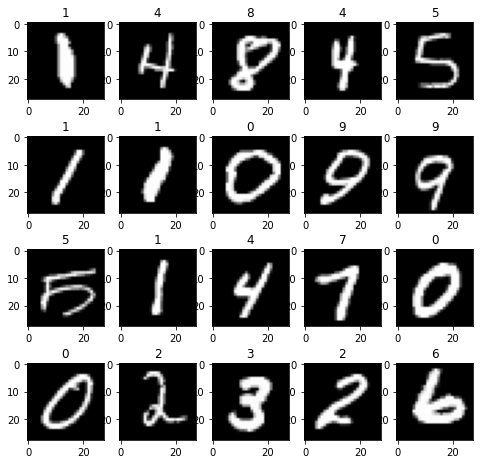

In [ ]:
# Digits Visualisation

fig = plt.figure(figsize=(8, 8))
# ax.ravel()
for x in range(1,21):
  index=np.random.randint(60000)
  fig.add_subplot(4, 5, x)
  plt.imshow(X_train[index],cmap='gray')
  
  plt.title(y_train[index])
plt.show()

In [ ]:
#checking the shape of data
X_train.shape,X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [ ]:
#as the shape is 28 by 28 for each image and there is no colour channel so in 
#order to apply convolution operation we need to add one colour channel
X_train = X_train/255
X_test = X_test/255

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

In [ ]:
X_train.shape,X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:

#CONSTRucting encoder
image_width = X_train.shape[1]
image_height = X_train.shape[2]
channels = X_train.shape[3]
latent_space_dim = 2 # dimension of the latent space

encoder_input = Input(shape=(image_height,image_width,channels),name='Enoder_Input')
x = Conv2D(filters=32,kernel_size=3,strides=1,padding='same',
                      name='EncoderConv1')(encoder_input)
x = LeakyReLU(name='LeakyReLU_1')(x)
x = Conv2D(filters=64,kernel_size=3,strides=2,padding='same',
                      name='EncoderConv2')(x)
x = LeakyReLU(name='LeakyReLU_2')(x)
x = Conv2D(filters=64,kernel_size=3,strides=2,padding='same',
                      name='EncoderConv3')(x)
x = LeakyReLU(name='LeakyReLU_3')(x)
x = Conv2D(filters=64,kernel_size=3,strides=1,padding='same',
                      name='EncoderConv4')(x)
x = LeakyReLU(name='LeakyReLU_4')(x)

# Storing Shape before flattening as it will be usefull in case of encoder to 
# convert latent space input back to this dimension to perform further operations
# of decoding
shape_before_flattening = K.int_shape(x)[1:] 
x = Flatten()(x)
x = Dense(32,activation='relu')(x)

######
###### Instead Of directly Connecting it to output of latent space, Connecting 
## it to mu and sigma layer to perform certain operation

## LATENT SPACE DIMENSION IS USED HERE
mu = Dense(latent_space_dim,name='latent_mu')(x)
sigma = Dense(latent_space_dim,name='latent_sigma')(x)


#Model that takes input image and gives relevant mu and sigma values
encoder_mu_log_sigma = Model(encoder_input,(mu,sigma)) # Not a necessary step as such

# Creating Function to be used in a model Throug LAMBDA LAYER
def sampling(args):
  mu, sigma = args
  epsilon = K.random_normal(K.shape(mu),mean = 0.,stddev=1.0)
  return mu + K.exp(sigma / 2) * epsilon

z = Lambda(sampling,output_shape=(latent_space_dim,),name='encoder_output')([mu,sigma])

encoder = Model(encoder_input,[mu,sigma,z])
encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Enoder_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 EncoderConv1 (Conv2D)          (None, 28, 28, 32)   320         ['Enoder_Input[0][0]']           
                                                                                                  
 LeakyReLU_1 (LeakyReLU)        (None, 28, 28, 32)   0           ['EncoderConv1[0][0]']           
                                                                                                  
 EncoderConv2 (Conv2D)          (None, 14, 14, 64)   18496       ['LeakyReLU_1[0][0]']            
                                                                                            

In [ ]:
decoder_input = Input(shape=(latent_space_dim,),name='decoder_input')

x = Dense(np.prod(shape_before_flattening),activation='relu')(decoder_input)# np.prod() multiplies all th eelemnt to give same no. of nodes as encoder
x = Reshape(shape_before_flattening)(x)
x = Conv2DTranspose(filters=64,padding='same',kernel_size=3,strides=1
                    ,name='ConveT_Decoder1')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters=64,padding='same',strides=2,kernel_size=3
                    ,name='ConveT_Decoder2')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters=32,padding='same',strides=2,kernel_size=3
                    ,name='ConveT_Decoder3')(x)
x = LeakyReLU()(x)

## filters = 1 in next layer as it is equal to number of channels
x = Conv2DTranspose(filters=1,padding='same',strides=1,
                    kernel_size = 3,name='ConveT_decoder4',activation='sigmoid')(x)
# Decoder_output = Activation('sigmoid')(x)

decoder = Model(decoder_input,x)

decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 ConveT_Decoder1 (Conv2DTran  (None, 7, 7, 64)         36928     
 spose)                                                          
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 7, 64)          0         
                                                                 
 ConveT_Decoder2 (Conv2DTran  (None, 14, 14, 64)       36928     
 spose)                                                    

In [ ]:
shape_before_flattening

(7, 7, 64)

In [ ]:
z_decoded = decoder(z)

In [ ]:

class CustomLayer(tf.keras.layers.Layer):

  def vae_loss(self,x,z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)

    #reconstruction loss
    recon_loss = tf.keras.metrics.binary_crossentropy(x,z_decoded)
    
    #kl divergence loss
    kl_loss = -5e-4 * K.mean(1 + sigma - K.square(mu) - K.exp(sigma),axis=-1)
    return K.mean(recon_loss + kl_loss)

  def call(self,inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x,z_decoded)
    self.add_loss(loss,inputs = inputs)
    return x

In [ ]:
## applying the custom loss to the input images and the decoded latent space distribution
y = CustomLayer()([encoder_input,z_decoded])

## y is basically the original image after encoding input img to mu,sigma, z
# and decoding sampled z values.
# This will be  used as output for VAE



In [ ]:
######### VAE

vae = Model(encoder_input,y,name='VAE')

vae.summary()


Model: "VAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Enoder_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 EncoderConv1 (Conv2D)          (None, 28, 28, 32)   320         ['Enoder_Input[0][0]']           
                                                                                                  
 LeakyReLU_1 (LeakyReLU)        (None, 28, 28, 32)   0           ['EncoderConv1[0][0]']           
                                                                                                  
 EncoderConv2 (Conv2D)          (None, 14, 14, 64)   18496       ['LeakyReLU_1[0][0]']            
                                                                                                

In [ ]:
vae.compile(optimizer='adam',loss=None)
vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Enoder_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 EncoderConv1 (Conv2D)          (None, 28, 28, 32)   320         ['Enoder_Input[0][0]']           
                                                                                                  
 LeakyReLU_1 (LeakyReLU)        (None, 28, 28, 32)   0           ['EncoderConv1[0][0]']           
                                                                                                  
 EncoderConv2 (Conv2D)          (None, 14, 14, 64)   18496       ['LeakyReLU_1[0][0]']            
                                                                                                

In [ ]:
vae.fit(X_train,None,epochs = 20,batch_size = 32,
        validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
47968/48000 [============================>.] - ETA: 0s - loss: 0.2218

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


48000/48000 [==============================] - 38s 793us/sample - loss: 0.2218 - val_loss: 0.1994
Epoch 2/20
48000/48000 [==============================] - 23s 488us/sample - loss: 0.1980 - val_loss: 0.1943
Epoch 3/20
48000/48000 [==============================] - 25s 514us/sample - loss: 0.1937 - val_loss: 0.1919
Epoch 4/20
48000/48000 [==============================] - 21s 448us/sample - loss: 0.1911 - val_loss: 0.1923
Epoch 5/20
48000/48000 [==============================] - 28s 576us/sample - loss: 0.1891 - val_loss: 0.1875
Epoch 6/20
48000/48000 [==============================] - 27s 556us/sample - loss: 0.1870 - val_loss: 0.1857
Epoch 7/20
48000/48000 [==============================] - 22s 463us/sample - loss: 0.1853 - val_loss: 0.1838
Epoch 8/20
48000/48000 [==============================] - 26s 544us/sample - loss: 0.1838 - val_loss: 0.1832
Epoch 9/20
48000/48000 [==============================] - 24s 497us/sample - loss: 0.1828 - val_loss: 0.1823
Epoch 10/20
48000/48000 [=====

In [ ]:
tf.__version__

'2.8.0'

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


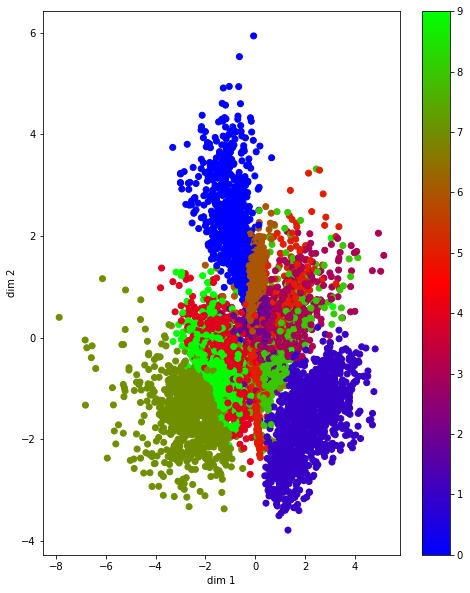

In [ ]:
mu, _, _ = encoder.predict(X_test)
#plot dim1 and dim2 for mu
plt.figure(figsize=(8,10))
plt.scatter(mu[:,0],mu[:,1],c=y_test,cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

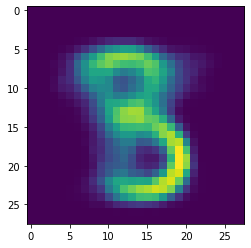

In [ ]:
# Image visulaisation
#s
sample_vector = np.array([[2,.5]])
decode_example = decoder.predict(sample_vector)
decoded_example_reshaped = decode_example.reshape(28,28)
plt.imshow(decoded_example_reshaped)

In [ ]:
# n = 20
# figure = np.zeros((28*28*1))

# grid_x = np.linspace(-4,4,n)
# grid_y = np.linspace(-4,5,n)[::-1]

# for i,yi in enumerate(grid_y):
#   for j,xi in enumerate(grid_x):
#     z_sample = np.array([[xi,yi]])
#     x_decoded = decoder.predict(z_sample)
#     digit = x_decoded[0].reshape(28*28*1)
#     figure[i*28:(i + 1)*28 , j*28:(j+1)*28] = digit

# plt.figure(figsize=(10,10))

# fig_shape = np.shape(figure)
# figure = figure.reshape((fig_shape[0],fig_shape[1]))

# plt.imshow(figure,cmap='gnuplot2')
# plt.show()

SyntaxError: ignored

In [ ]:
def display_image_sequence(x_start, y_start, x_end, y_end, no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2])
    
    # Display some images
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                             sharey=True, figsize=(20, 7))
    counter = 0
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='gray')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()

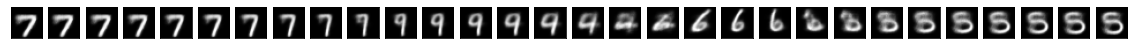

In [ ]:
# Starting point=(0,-2), end point=(0,2)
display_image_sequence(-4,-2,2,2,30)